https://www.kaggle.com/competitions/reconocimiento-de-expresiones-faciales

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from skimage.io import imread
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras 
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob 
import warnings
warnings.filterwarnings('ignore')


.

### READ DATA 

In [2]:
data_path = './data/train'
pd.DataFrame(os.listdir(data_path),columns=['File_Name'])

,File_Name
0,angry
1,disgust
2,fear
3,happy
4,neutral
5,sad
6,surprise


In [3]:
files = [i for i in glob.glob(data_path + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("\\")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns = ["Image", "Label"])
dataframe

,Image,Label
0,./data/train\sad\20317.jpg,sad
1,./data/train\neutral\10912.jpg,neutral
2,./data/train\fear\1608.jpg,fear
3,./data/train\happy\16187.jpg,happy
4,./data/train\surprise\15317.jpg,surprise
...,...,...
28816,./data/train\neutral\12247.jpg,neutral
28817,./data/train\happy\22294.jpg,happy
28818,./data/train\fear\18302.jpg,fear
28819,./data/train\sad\17490.jpg,sad


### VISUALIZATION

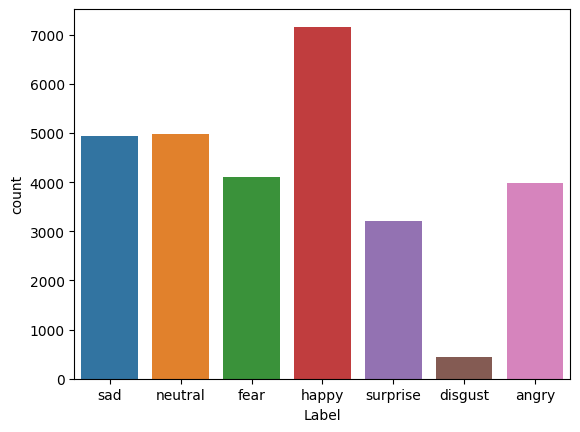

In [4]:
import matplotlib.pyplot as plotter

sns.countplot(x = dataframe["Label"], hue=dataframe["Label"])
plotter.xticks(rotation = 0);

### PREPROCESSING

In [5]:
# Hiperparametros:

batch_size = 64
target_size = (224,224)
validation_split = 0.2

In [6]:
train= tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

validation= tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

Found 28821 files belonging to 7 classes.
Using 23057 files for training.
Found 28821 files belonging to 7 classes.
Using 5764 files for validation.


In [7]:
train_size = len(train)
val_size = len(validation)
total = train_size + val_size

print(f'train samples count:\t\t{train_size}\t({(100 * train_size/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size/total):.2f}%)')
print('================================================')
print(f'Total:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

train samples count:		361	(79.87%)
validation samples count:	91	(20.13%)
Total:				452	(100.00%)


In [8]:
class_names=train.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

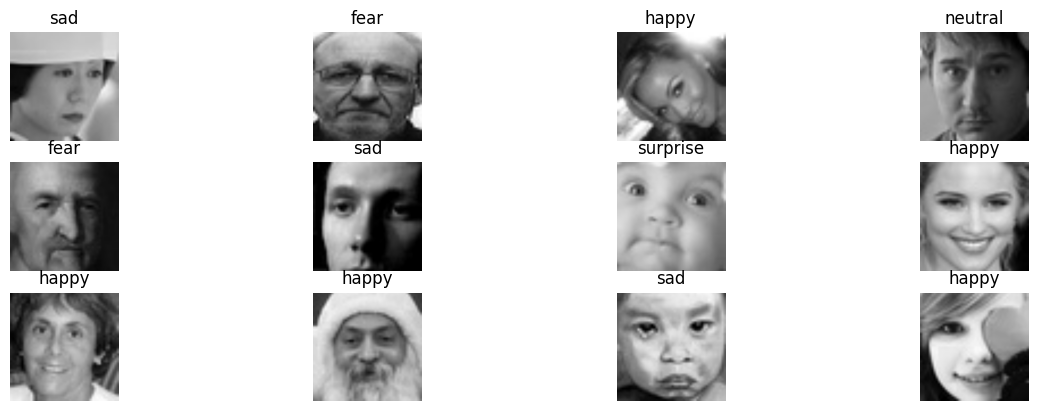

In [9]:
plt.figure(figsize=(15, 20))
for images, labels in train.take(1):
    for i in range(12):
        ax = plt.subplot(12, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### MODELING

In [10]:
base_model = tf.keras.applications.EfficientNetV2M(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
keras_model=keras.models.Sequential()
keras_model.add(base_model)
keras_model.add(keras.layers.Flatten()) 
keras_model.add(keras.layers.Dropout(0.5))
keras_model.add(keras.layers.Dense(7,activation=tf.nn.softmax))
#keras_model.summary()

In [11]:
checkpoint =ModelCheckpoint("model_TCKFaces.keras", save_best_only=True)
early_stopping =EarlyStopping(patience=10, restore_best_weights=True)
keras_model.compile(optimizer ='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = keras_model.fit(train,epochs=40,validation_data=validation,callbacks=[checkpoint,early_stopping])

Epoch 1/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 3160s 9s/step - accuracy: 0.3984 - loss: 3.0354 - val_accuracy: 0.5798 - val_loss: 2.0146
Epoch 2/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 3122s 9s/step - accuracy: 0.4999 - loss: 2.7180 - val_accuracy: 0.6143 - val_loss: 1.9211
Epoch 3/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 3136s 9s/step - accuracy: 0.5276 - loss: 2.7921 - val_accuracy: 0.6449 - val_loss: 1.8795
Epoch 4/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 3129s 9s/step - accuracy: 0.5499 - loss: 2.8499 - val_accuracy: 0.6376 - val_loss: 2.3146
Epoch 5/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 3148s 9s/step - accuracy: 0.5645 - loss: 2.8882 - val_accuracy: 0.6751 - val_loss: 1.9461
Epoch 6/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 3185s 9s/step - accuracy: 0.5703 - loss: 2.9819 - val_accuracy: 0.6868 - val_loss: 1.8439
Epoch 7/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 3119s 9s/step - accuracy: 0.5855 - loss: 2.9570 - val_accuracy: 0.7103 - val_loss: 1.7720
Epoch 8/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 3182s 9s/step - accuracy: 0.5972 - loss: 2.9522 - 

In [13]:
hist=pd.DataFrame(history.history)
hist

,accuracy,loss,val_accuracy,val_loss
0,0.429197,2.900084,0.579806,2.014635
1,0.502667,2.759819,0.614330,1.921076
2,0.533504,2.779803,0.644865,1.879518
3,0.554452,2.861401,0.637578,2.314580
4,0.568114,2.897982,0.675052,1.946072
5,0.575877,2.938349,0.686849,1.843882
6,0.585549,2.979690,0.710271,1.772025
7,0.598907,2.971024,0.722242,1.692733
8,0.608535,2.963809,0.715302,1.881462
9,0.607928,3.020027,0.733171,1.804336


### Visualization of model

In [14]:
def evaluate_model(model, data):
    test_loss, test_accuracy = model.evaluate(data, steps=len(data))
    print(f"Loss validate dataset: { test_loss }")
    print(f"Accuracy validate dataset: { test_accuracy }")

In [15]:
evaluate_model(keras_model, validation)

91/91 ━━━━━━━━━━━━━━━━━━━━ 599s 7s/step - accuracy: 0.7678 - loss: 1.7283
Loss validate dataset: 1.6875321865081787
Accuracy validate dataset: 0.7756766080856323


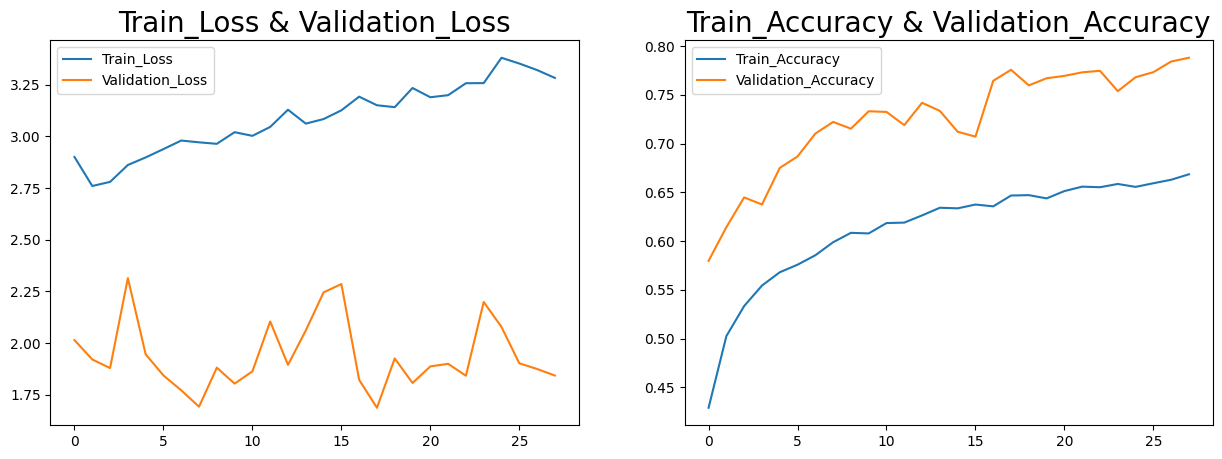

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist['loss'],label='Train_Loss')
plt.plot(hist['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['accuracy'],label='Train_Accuracy')
plt.plot(hist['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

# Real Test

In [17]:
test_path = './data/test'

In [18]:
test= tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=target_size,
    batch_size=batch_size,
    shuffle=False
)

Found 7066 files belonging to 1 classes.


In [19]:
pred = keras_model.predict(test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 767s 7s/step


In [20]:
predicted_classes = np.argmax(pred, axis=1)

In [21]:
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [22]:
dict_emotions = {
    0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'neutral',
    5:'sad',
    6:'surprise'
}

In [23]:
pred_class_mapped = np.array([dict_emotions[num] for num in predicted_classes])

In [24]:
list_id = []
for file in os.listdir('./data/test/all'):
    id = file.split('.')[0]
    list_id.append(id)

In [25]:
df_pred = pd.DataFrame(list_id, columns = ["id_img"])
df_pred['label'] = pred_class_mapped

In [26]:
submission = df_pred

In [27]:
sample = pd.read_csv('sample_submision.csv')

In [28]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.index.all() == sample.index.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("")


In [29]:
chequeator(submission)

You're ready to submit!
